In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import scipy as sp
import pandas as pd
import seaborn
import nltk.stem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics

In [2]:
num_clusters = 25

In [3]:
dataset = fetch_20newsgroups(subset='all') # Fetch the entire dataset
print("Number of total posts: %i" % len(dataset.filenames)) # Code from textbook

Number of total posts: 18846


In [4]:
train_data = fetch_20newsgroups(subset='train', 
                                random_state=42,
                                remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test',
                               random_state=42,
                               remove=('headers', 'footers', 'quotes'))

In [5]:
test_labels, train_labels = test_data.target, train_data.target

In [6]:
# Make a dataframe object for training and testing data.  Labels correspond to the 20 different
# news groups
train = {'Labels': train_labels, 'Posts': train_data.data}
train_df = pd.DataFrame(data=train)
train_df

,Labels,Posts
0,7,I was wondering if anyone out there could enli...
1,4,A fair number of brave souls who upgraded thei...
2,4,"well folks, my mac plus finally gave up the gh..."
3,1,\nDo you have Weitek's address/phone number? ...
4,14,"From article <C5owCB.n3p@world.std.com>, by to..."
...,...,...
11309,13,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310,4,"I have a (very old) Mac 512k and a Mac Plus, b..."
11311,3,I just installed a DX2-66 CPU in a clone mothe...
11312,1,\nWouldn't this require a hyper-sphere. In 3-...


In [7]:
test = {'Labels': test_labels, 'Posts': test_data.data}
test_df = pd.DataFrame(data=test) 
test_df

,Labels,Posts
0,7,I am a little confused on all of the models of...
1,5,I'm not familiar at all with the format of the...
2,0,"\nIn a word, yes.\n"
3,17,\nThey were attacking the Iraqis to drive them...
4,19,\nI've just spent two solid months arguing tha...
...,...,...
7527,14,"\n Henry, if I read you correctly, you may b..."
7528,4,"about\nthem on\n\nActually, I thought Macs wer..."
7529,9,"I sent a version of this post out a while ago,..."
7530,6,I have this kit which includes the following :...


In [8]:
# Need to use stemming to count words that have similar meaning by comparing their stems
english_stemmer =nltk.stem.SnowballStemmer('english')

In [9]:
#Class to convert text to a bag-of-words vector of counts using sklearn CountVectorizer
# Note: tfidf stands for term frequency - inverse document frequency.  This is helpful for
# de-noising the data i.e. penalizing words that occur in many posts, while focusing more 
# on words that occur often in fewer posts.  
class StemmedTfidfVectorizer(TfidfVectorizer):
    '''This code comes from the Richert textbook code'''
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

In [10]:
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5,
                                    stop_words='english', 
                                    decode_error='ignore')
vectorized_train = vectorizer.fit_transform(train_data.data)

In [11]:
vectorized_train

<11314x7824 sparse matrix of type '<class 'numpy.float64'>'
	with 579601 stored elements in Compressed Sparse Row format>

In [12]:
kmeans25 = KMeans(n_clusters=25,
                  n_init = 1,
                  verbose = 1,
                  random_state=1)

In [13]:
clustered = kmeans25.fit(vectorized_train)

Initialization complete
Iteration 0, inertia 10934.798705831407
Iteration 1, inertia 10742.998764236057
Iteration 2, inertia 10734.215790169914
Iteration 3, inertia 10722.144798335206
Iteration 4, inertia 10712.76744545523
Iteration 5, inertia 10707.848136714269
Iteration 6, inertia 10705.537342949268
Iteration 7, inertia 10704.646295812023
Iteration 8, inertia 10704.305110856507
Iteration 9, inertia 10704.14442671018
Iteration 10, inertia 10703.980990159089
Iteration 11, inertia 10703.883085026719
Iteration 12, inertia 10703.81443259938
Iteration 13, inertia 10703.779791632258
Iteration 14, inertia 10703.765658477743
Iteration 15, inertia 10703.755397897718
Iteration 16, inertia 10703.752086526785
Converged at iteration 16: strict convergence.


In [36]:
#for i in kmeans25.labels_: print(kmeans25.labels_[i])

[Text(0.5, 1.0, 'Bar Chart for K=25 Clusters'), Text(0.5, 0, 'Cluster')]

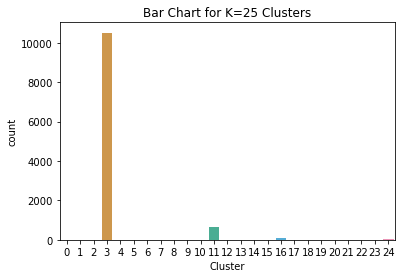

In [15]:
k25labels = pd.DataFrame({'Labels':kmeans25.labels_})
seaborn.countplot(x=kmeans25.labels_).set(title='Bar Chart for K=25 Clusters', xlabel='Cluster')

In [16]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(train_labels, kmeans25.labels_))
# Homogeneity: 0.400
print("Completeness: %0.3f" % metrics.completeness_score(train_labels, kmeans25.labels_))
# Completeness: 0.206
print("V-measure: %0.3f" % metrics.v_measure_score(train_labels, kmeans25.labels_))
# V-measure: 0.272
print("Adjusted Rand Index: %0.3f" %
      metrics.adjusted_rand_score(train_labels, kmeans25.labels_))
# Adjusted Rand Index: 0.064
print("Adjusted Mutual Information: %0.3f" %
      metrics.adjusted_mutual_info_score(train_labels, kmeans25.labels_))
# Adjusted Mutual Information: 0.197
print(("Silhouette Coefficient: %0.3f" %
       metrics.silhouette_score(vectorized_train, train_labels, sample_size=1000)))
# Silhouette Coefficient: 0.006

Homogeneity: 0.054
Completeness: 0.508
V-measure: 0.098
Adjusted Rand Index: 0.006
Adjusted Mutual Information: 0.091
Silhouette Coefficient: -0.013


In [17]:
new_post = \
    """Disk drive problems. Hi, I have a problem with my hard disk.
After 1 year it is working only sporadically now.
I tried to format it, but now it doesn't boot any more.
Any ideas? Thanks.
"""

next_post = \
"""Looking for an Indian motorbike in mint condition.  I want it like new, with
big tires and a comfortable seat.  I am willing to pay thirty dollars for 
this ride.  Help me out?"""

last_post = \
"""Do atheists believe in God?"""

In [18]:
new_post_vector = vectorizer.transform([new_post])
new_post_label = kmeans25.predict(new_post_vector)[0]

In [19]:
similar_indices = (kmeans25.labels_ == new_post_label).nonzero()[0]

In [20]:
similar = []
for i in similar_indices:
    dist = sp.linalg.norm((new_post_vector - vectorized_train[i]).toarray())
    similar.append((dist, train_data.data[i])) 

In [21]:
similar = sorted(similar)
print("Count similar: %i" % len(similar))

show_at_1 = similar[0]
show_at_2 = similar[int(len(similar) / 10)]
show_at_3 = similar[int(len(similar) / 2)]

print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

print("=== #4 ===")
print(similar[-1])

Count similar: 10516
=== #1 ===
(0.9491516479437525, "Hi,\nI've got a Multi I/O card (IDE controller + serial/parallel\ninterface) and two floppy drives (5 1/4, 3 1/2) and a\nQuantum ProDrive 80AT connected to it.\nI was able to format the hard disk, but I could not boot from\nit. I can boot from drive A: (which disk drive does not matter)\nbut if I remove the disk from drive A and press the reset switch,\nthe LED of drive A: continues to glow, and the hard disk is\nnot accessed at all.\nI guess this must be a problem of either the Multi I/o card\nor floppy disk drive settings (jumper configuration?)\nDoes someone have any hint what could be the reason for it.\nPlease reply by email to GERTHD@MVS.SAS.COM\nThanks,\nThomas\n+-------------------------------------------------------------------+\n+-------------------------------------------------------------------+\n")

=== #2 ===
(1.3602155478485611, "\nActually, info@qdeck.com is our customer service department. If you have\ntechnical que

In [22]:
next_post_vector = vectorizer.transform([next_post])
next_post_label = kmeans25.predict(next_post_vector)[0]

In [23]:
similar_indices = (kmeans25.labels_ == next_post_label).nonzero()[0]

In [24]:
similar = []
for i in similar_indices:
    dist = sp.linalg.norm((next_post_vector - vectorized_train[i]).toarray())
    similar.append((dist, train_data.data[i])) 

In [25]:
similar = sorted(similar)
print("Count similar: %i" % len(similar))

show_at_1 = similar[0]
show_at_2 = similar[int(len(similar) / 10)]
show_at_3 = similar[int(len(similar) / 2)]

print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

print("=== #4 ===")
print(similar[-1])

Count similar: 10516
=== #1 ===
(0.9999999999999998, '')

=== #2 ===
(1.3839227905813696, ': From: brad@optilink.COM (Brad Yearwood)\n\n: Assume in this case the usual canard-adversary of narcotraficantes.  They\n: probably have more cash than the KGB did, and they\'re probably more generous\n: at handing it out.  It will be easier than ever to find or cultivate Walkers\n: and Pollards for the keys, and it will be easy enough to find someone to\n: reverse-engineer the chip (unless the tamper proofing is damned clever and\n: effective).\n\nIf the administration *really* believes big-time drug dealers are the threat\n(personally I thought it was the CIA and the air force that did all the real\ndrug shipping :-) ) then they *ought* to take this seriously: unlike the\nKGB, drug dealers can make a most convincing argument for cooperation: "help\nus and we\'ll be nice and give you some money, don\'t help us and we\'ll start\ncutting off your favourite body parts"\n\nAfter all, it was probabl

In [26]:
last_post_vector = vectorizer.transform([last_post])
last_post_label = kmeans25.predict(last_post_vector)[0]

In [27]:
similar_indices = (kmeans25.labels_ == last_post_label).nonzero()[0]

In [28]:
similar = []
for i in similar_indices:
    dist = sp.linalg.norm((last_post_vector - vectorized_train[i]).toarray())
    similar.append((dist, train_data.data[i]))

In [29]:
similar = sorted(similar)
print("Count similar: %i" % len(similar))

show_at_1 = similar[0]
show_at_2 = similar[int(len(similar) / 10)]
show_at_3 = similar[int(len(similar) / 2)]

print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

print("=== #4 ===")
print(similar[-1])

Count similar: 642
=== #1 ===
(0.8504556061851828, 'Archive-name: atheism/introduction\nAlt-atheism-archive-name: introduction\nLast-modified: 5 April 1993\nVersion: 1.2\n\n-----BEGIN PGP SIGNED MESSAGE-----\n\n                          An Introduction to Atheism\n                       by mathew <mathew@mantis.co.uk>\n\nThis article attempts to provide a general introduction to atheism.  Whilst I\nhave tried to be as neutral as possible regarding contentious issues, you\nshould always remember that this document represents only one viewpoint.  I\nwould encourage you to read widely and draw your own conclusions; some\nrelevant books are listed in a companion article.\n\nTo provide a sense of cohesion and progression, I have presented this article\nas an imaginary conversation between an atheist and a theist.  All the\nquestions asked by the imaginary theist are questions which have been cropped\nup repeatedly on alt.atheism since the newsgroup was created.  Some other\nfrequently asked

In [30]:
# Now, vectorize the testing data and make predictions using the model
vectorized_test = vectorizer.fit_transform(test_df['Posts'])

In [31]:
predictions = kmeans25.fit_predict(vectorized_test)

Initialization complete
Iteration 0, inertia 7261.7926300772115
Iteration 1, inertia 7141.709328848494
Iteration 2, inertia 7126.112902452051
Iteration 3, inertia 7112.238596975514
Iteration 4, inertia 7100.80638750309
Iteration 5, inertia 7091.075379554677
Iteration 6, inertia 7085.174581071586
Iteration 7, inertia 7083.009061983382
Iteration 8, inertia 7081.815083568512
Iteration 9, inertia 7080.950955205795
Iteration 10, inertia 7080.259541377225
Iteration 11, inertia 7079.891871767545
Iteration 12, inertia 7079.594740874109
Iteration 13, inertia 7079.405078448914
Iteration 14, inertia 7079.262442233552
Iteration 15, inertia 7079.154150472899
Iteration 16, inertia 7079.066493765438
Iteration 17, inertia 7078.997424431562
Iteration 18, inertia 7078.966321508829
Iteration 19, inertia 7078.925387735378
Iteration 20, inertia 7078.909550976908
Iteration 21, inertia 7078.893695295434
Iteration 22, inertia 7078.882966218344
Converged at iteration 22: strict convergence.


In [32]:
predictions

array([ 7,  7,  7, ...,  7,  7, 22])

In [33]:
adjusted_rand_score(test_df['Labels'], predictions)

0.008861141788358187

In [34]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(test_labels, predictions))
print("Completeness: %0.3f" % metrics.completeness_score(test_labels, predictions))

Homogeneity: 0.079
Completeness: 0.420


[Text(0.5, 1.0, 'Bar Chart for Cluster Elements'), Text(0.5, 0, 'Cluster')]

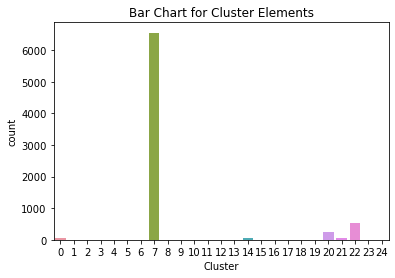

In [35]:
seaborn.countplot(x=predictions).set(title='Bar Chart for Cluster Elements', xlabel='Cluster')